In [17]:
# example making new class predictions for a classification problem
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
# generate 2d classification dataset
# X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)
# scalar = MinMaxScaler()
# scalar.fit(X)
# X = scalar.transform(X)

In [18]:
def generating_test_data_any_distributions(how_many_times_repeat, iterations, parameters):

    mu1 = parameters[0]
    sigma1 = parameters[1]
    mu2 = parameters[2]
    sigma2 = parameters[3]
    dim = len(mu1)

    testing_data=[]
    belonging_classes=[]

    for repeat in range(how_many_times_repeat):

        random_simulation = np.zeros((iterations,dim))
        which_class_list = np.zeros((iterations,))

        for itera in range(iterations):

            which_normal = random.randint(0,1)

            if which_normal == 0:

                if dim == 1:
                    random_simulation[itera,:] = np.random.normal(mu1, sigma1)
                else:
                    random_simulation[itera,:] = np.random.multivariate_normal(mu1, sigma1)


            else:

                if dim == 1:
                    random_simulation[itera,:] = np.random.normal(mu2, sigma2)
                else:
                     random_simulation[itera,:] = np.random.multivariate_normal(mu2, sigma2)


            which_class_list[itera,] = which_normal

        testing_data.append(random_simulation)
        belonging_classes.append(which_class_list)


    return testing_data, belonging_classes



def create_bins(data, data_test, how_many_bins, how_to_bin):
    mi = min(min(data), min(data_test))
    ma = max(max(data), max(data_test))
    if how_to_bin =='cons_std':
        bin_size = how_many_bins * np.std(data)
        start = (mi + ma)/2

        bins_right = [start]
        current_right = 1.0 * start

        while current_right  < ma:
            current_right += bin_size
            bins_right.append(current_right)

        bins_left = []
        current_left = 1.0 * start
        while current_left  > mi:
            current_left -= bin_size
            bins_left.append(current_left)

        bins = np.concatenate((bins_left[::-1],bins_right))
    elif how_to_bin =='fixed_number':
        bins = np.linspace(mi-0.00000001, ma+0.00000001,how_many_bins)
    else:
        assert('Way of binning unknown')
    return bins



def split_train_test(df, target_variable, indices_test = False):

    how_many_0s = len(df[df[target_variable] == 0])
    how_many_1s = len(df[df[target_variable] == 1])
    size = how_many_0s + how_many_1s

    randomlist = random.sample(list(df[df[target_variable]==0].index.values), 4 * how_many_0s // 5) + random.sample(list(df[df[target_variable]==1].index.values), 4 * how_many_1s // 5)
    not_in_randomlist = list(set(range(0,size)) - set(randomlist))

    df_test = df.iloc[not_in_randomlist,:]
    df_train = df.iloc[randomlist,:]
    df_train.sort_index(inplace=True)
    df_train.reset_index(inplace=True, drop = True)
    df_test.reset_index(inplace=True, drop = True)
    if indices_test:
        return df_train, df_test, not_in_randomlist
    else:
        return df_train, df_test



def dataset_to_Xandy(dataset, target_variable, only_X = True):
    X = dataset.loc[:, dataset.columns != target_variable]
    y = dataset.loc[:, dataset.columns == target_variable]

    if only_X:
        return X
    else:
        return X, y

In [19]:
how_many_times_repeat = 1
iterations = 1000
mu1 = np.array([0, 0, 0])
mu2 = np.array([1, 1, 1])
sigma1 = np.identity(len(mu1))
sigma2 =  np.identity(len(mu1))
parameters = [mu1, sigma1, mu2, sigma2]
testing_data, belonging_classes = generating_test_data_any_distributions(how_many_times_repeat, iterations, parameters)
names_columns = ['Feature_'+str(i+1) for i in range(len(mu1))]

In [20]:
target_variable = 'target'

df = pd.DataFrame(testing_data[0], columns = names_columns)
df[target_variable] = belonging_classes[0]
df.head()

,Feature_1,Feature_2,Feature_3,target
0,0.911583,0.079799,1.371301,1.0
1,0.272567,-1.014022,0.722789,0.0
2,0.299773,-0.982316,0.193580,0.0
3,1.625601,0.446822,1.702075,1.0
4,1.147127,1.662457,1.166403,1.0


In [21]:
how_many_bins = 20

which_column_to_categories = 'Feature_1' ######## this needs to be changed
bins_col3 = create_bins(df[which_column_to_categories], df[which_column_to_categories], how_many_bins+1, 'fixed_number')
categories = list(np.arange(1, how_many_bins+1))
digitized = np.digitize(df[which_column_to_categories],bins_col3)
df[which_column_to_categories] = digitized
df[which_column_to_categories] = df[which_column_to_categories].replace(categories, categories)
df.head()

,Feature_1,Feature_2,Feature_3,target
0,11,0.079799,1.371301,1.0
1,9,-1.014022,0.722789,0.0
2,9,-0.982316,0.193580,0.0
3,13,0.446822,1.702075,1.0
4,12,1.662457,1.166403,1.0


In [22]:
df_train, df_test, ind_test = split_train_test(df, target_variable, indices_test=True)

print('Train size: '+str(df_train.shape) +'\nTest size: '+str(df_test.shape)+'\n\n')

Train size: (800, 4)
Test size: (200, 4)




<ipython-input-18-0e733a7a38f9>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.sort_index(inplace=True)


In [23]:
X_train, y_train =  dataset_to_Xandy(df, target_variable, only_X = False) ###### the original dataset
X_test, y_test =  dataset_to_Xandy(df_test, target_variable, only_X = False) ###### the original dataset






In [24]:
# define and fit the final model
model = Sequential()
model.add(Dense(4, input_shape=(3,), activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X_train, y_train, epochs=500, verbose=0)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 16        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


7/7 [==============================] - 0s 4ms/step


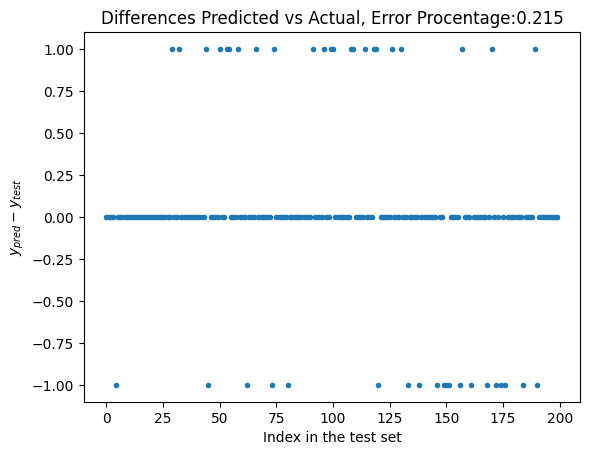

In [26]:
# make a prediction
ynew =  (model.predict(X_test) > 0.5).astype("int32")

plt.plot(ynew-y_test,'.')
plt.title('Differences Predicted vs Actual, Error Procentage:'+str(sum(np.abs(ynew-y_test)[target_variable])/len(ynew)))
plt.xlabel('Index in the test set')
plt.ylabel('$y_{pred} - y_{test}$')
plt.show()

In [27]:
def dict_pos_neg(df, feature, target_variable, categories):
  column_to_replace = df[which_column_to_categories]
  dictionary_pos_neg = {}
  for cat in categories:
     which_cat = df[df[feature] == cat]
     if which_cat.shape[0] > 1:
      dictionary_pos_neg[cat] = np.array([which_cat[which_cat[target_variable] == 0].shape[0], which_cat[which_cat[target_variable] == 1].shape[0]])
  unique_cat_train = list(set(categories) - set(dictionary_pos_neg.keys()))
  for cat in unique_cat_train:
    dictionary_pos_neg[cat] = [df[df[target_variable] == 0].shape[0], df[df[target_variable] == 1].shape[0]]
  return dictionary_pos_neg

dictionary_pos_neg = dict_pos_neg(df_train, which_column_to_categories, target_variable, categories)
dictionary_pos_neg

{1: array([2, 0]),
 2: array([5, 0]),
 3: array([15,  2]),
 4: array([17,  4]),
 5: array([21,  4]),
 6: array([37,  8]),
 7: array([43, 15]),
 8: array([65, 42]),
 9: array([59, 37]),
 10: array([43, 45]),
 11: array([33, 60]),
 12: array([26, 60]),
 13: array([13, 44]),
 14: array([ 5, 34]),
 15: array([ 4, 27]),
 16: array([2, 9]),
 17: array([ 2, 11]),
 18: array([0, 2]),
 19: array([0, 2]),
 20: array([0, 2])}

In [28]:
X_train.head()

,Feature_1,Feature_2,Feature_3
0,11,0.079799,1.371301
1,9,-1.014022,0.722789
2,9,-0.982316,0.193580
3,13,0.446822,1.702075
4,12,1.662457,1.166403


In [29]:
dictionary_pos_neg.values()

dict_values([array([2, 0]), array([5, 0]), array([15,  2]), array([17,  4]), array([21,  4]), array([37,  8]), array([43, 15]), array([65, 42]), array([59, 37]), array([43, 45]), array([33, 60]), array([26, 60]), array([13, 44]), array([ 5, 34]), array([ 4, 27]), array([2, 9]), array([ 2, 11]), array([0, 2]), array([0, 2]), array([0, 2])])

In [30]:
#### REPLACE EACH CATEGORY BY 2 VALUES: NR OF POS, NR OF NEG -> IN BOTH TRAIN & TEST


X_train_mod_1 = X_train.copy()
X_test_mod_1 = X_test.copy()


X_train_mod_1[which_column_to_categories+str('_N')] = X_train_mod_1[which_column_to_categories].copy()
X_train_mod_1.rename(columns={which_column_to_categories: which_column_to_categories+str('_P')}, inplace=True)

X_test_mod_1[which_column_to_categories+str('_N')] = X_test_mod_1[which_column_to_categories].copy()
X_test_mod_1.rename(columns={which_column_to_categories: which_column_to_categories+str('_P')}, inplace=True)



for cat in categories:
  n = dictionary_pos_neg[cat][0]
  p = dictionary_pos_neg[cat][1]
  X_train_mod_1[which_column_to_categories+str('_N')].replace(cat, n, inplace = True)
  X_train_mod_1[which_column_to_categories+str('_P')].replace(cat, p, inplace = True)
  X_test_mod_1[which_column_to_categories+str('_N')].replace(cat, n, inplace = True)
  X_test_mod_1[which_column_to_categories+str('_P')].replace(cat, p, inplace = True)
X_train_mod_1.head()


X_train_mod_1.to_csv('/content/drive/My Drive/x_train.csv', index=False)
X_test_mod_1.to_csv('/content/drive/My Drive/x_test.csv', index=False)
y_train.to_csv('/content/drive/My Drive/y_train.csv', index=False)
y_test.to_csv('/content/drive/My Drive/y_test.csv', index=False)


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
X_test_mod_1.head()

,Feature_1_P,Feature_2,Feature_3,Feature_1_N
0,37,-0.982316,0.193580,59
1,44,1.357731,-0.631987,13
2,42,-0.196216,0.057852,65
3,60,1.071773,-1.818958,26
4,60,-0.565636,0.360649,26


In [33]:
model = Sequential()
model.add(Dense(5, input_shape=(4,), activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X_train_mod_1, y_train, epochs=500, verbose=0)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 25        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


7/7 [==============================] - 0s 3ms/step


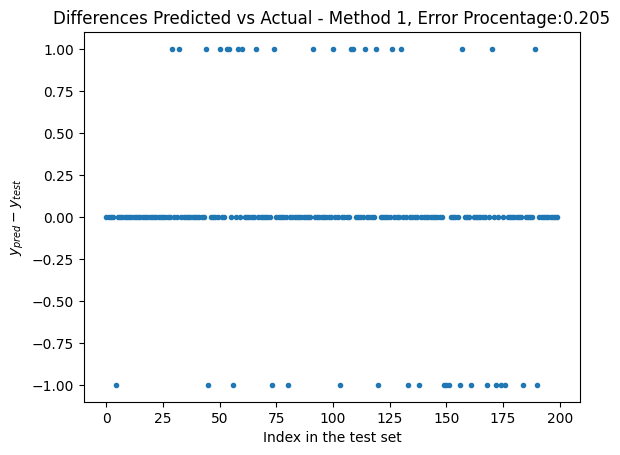

In [34]:
# make a prediction
ynew =  (model.predict(X_test_mod_1) > 0.5).astype("int32")

plt.plot(ynew-y_test,'.')
plt.title('Differences Predicted vs Actual - Method 1, Error Procentage:'+str(sum(np.abs(ynew-y_test)[target_variable])/len(ynew)))
plt.xlabel('Index in the test set')
plt.ylabel('$y_{pred} - y_{test}$')
plt.show()
